# Exploratory Data Analysis - Billboard Hot 100 & Spotify Track Data

## 1.0 Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
charts = pd.read_csv('../data/raw/chart-data', index_col=0)
songs = pd.read_csv('../data/raw/unique-songs', index_col=0)

In [3]:
charts['Date'] =  pd.to_datetime(charts['Date'], format='%Y-%m-%d')
charts.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19


In [4]:
#remove poor matches, blank sp_id and duplicate sp_id - 155 rows lost (~3%)
songs['Date'] =  pd.to_datetime(songs['Date'], format='%Y-%m-%d')
songs = songs[songs.Match_Ratio > 60].dropna(axis=0, subset=['SP_id']).\
                        drop_duplicates(subset='SP_id',keep=False).reset_index(drop = True)

#change number value of key to specific keys
songs['key'] = songs['key'].map({0.0: 'C', 1.0: 'C#, Db', 2.0: 'D',\
                                3.0: 'D#, Eb', 4.0: 'E', 5.0: 'F',\
                                6.0: 'F#, Gb', 7.0: 'G', 8.0: 'G#, Ab',\
                                9.0: 'A', 10.0: 'A#, Bb', 11.0: 'B'})
songs['mode'] = songs['mode'].map({0.0: 'Minor', 1.0: 'Major'})

songs.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6,STAY (with Justin Bieber),The Kid LAROI,100.0,...,-5.484,Major,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8,Bad Habits,Ed Sheeran,100.0,...,-3.712,Minor,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14,good 4 u,Olivia Rodrigo,100.0,...,-5.044,Major,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1,Rumors (feat. Cardi B),Lizzo,100.0,...,-5.524,Minor,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19,Kiss Me More (feat. SZA),Doja Cat,100.0,...,-3.541,Major,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


## 2.0 Billboard Chart EDA

In [5]:
by_year = charts.groupby(by=charts['Date'].dt.year).mean()

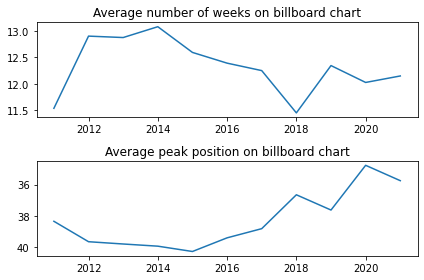

In [6]:
fig, ax = plt.subplots(2)

ax[0].plot(by_year.index.values, by_year['Weeks'])
ax[1].plot(by_year.index.values, by_year['PeakPos'])

ax[0].set_title('Average number of weeks on billboard chart')
ax[1].set_title('Average peak position on billboard chart')


fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 3.0 Unique Song Data EDA

In [7]:
songs['key'].value_counts()

C#, Db    676
C         508
G         430
D         401
G#, Ab    395
B         391
F#, Gb    383
A         377
F         357
A#, Bb    329
E         317
D#, Eb    112
Name: key, dtype: int64

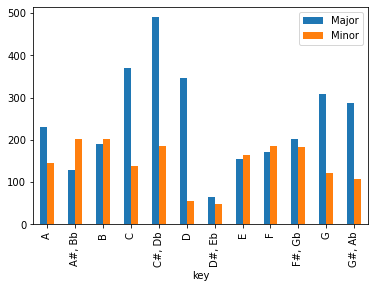

In [8]:
key_group = songs[['mode','key','BB_Title']].groupby(by=['key','mode']).count()

key_group.unstack().plot(kind='bar', stacked=False)
plt.legend(['Major','Minor'])
plt.show()

In [9]:
all_genres = [str(item) for item in songs['Genres'].to_list()]

genre_list = []

for item in all_genres:
    genre_list.extend(item.split(','))

#Counter(genre_list).most_common()

In [10]:
def scatterplots(columns, y, data, feature_key=[], invert=False, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        if invert == True:
            ax.invert_yaxis()
        ax.scatter(x = col, y = y, data=data, alpha=0.5)
        if col in feature_key:
            ax.set_xlim([0,1])
        ax.set(xlabel=col, ylabel=y)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

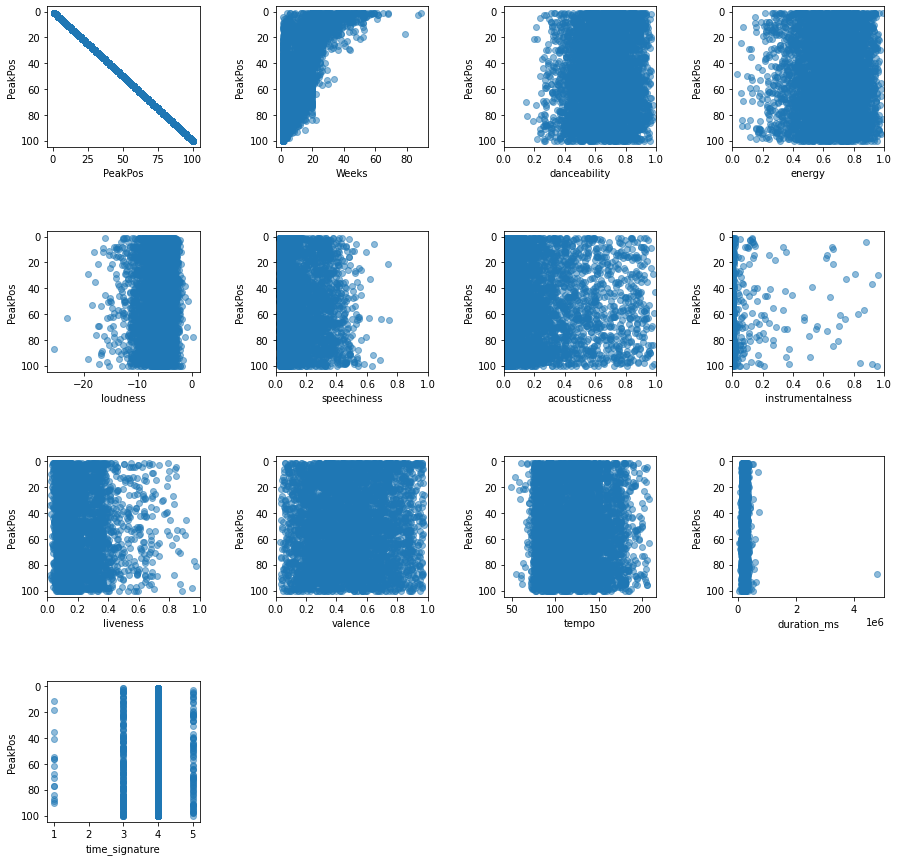

In [11]:
features = ['PeakPos', 'Weeks', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']
zero_to_one_features = [x for x in features if x not in ['PeakPos','Weeks','loudness',\
                                                         'tempo','duration_ms','time_signature']]
scatterplots(features, 'PeakPos', songs, feature_key=zero_to_one_features, invert=True, ncol=4, figsize=(15, 15))

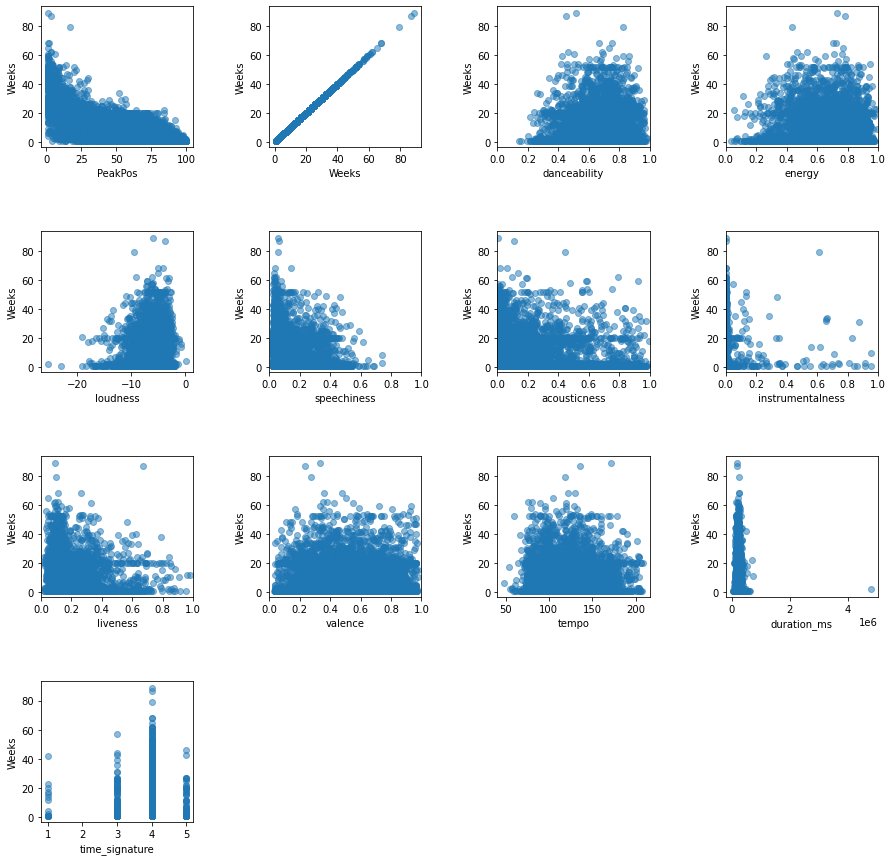

In [12]:
scatterplots(features, 'Weeks', songs, feature_key=zero_to_one_features, ncol=4, figsize=(15, 15))

### 3.1 Focus on PeakPos

In [13]:
peak_pos = songs.drop(columns=['Rank','LastPos','Match_Ratio']).groupby(pd.cut(songs["PeakPos"], \
                                                    np.arange(0, 100, 5))).mean()

#peak_pos

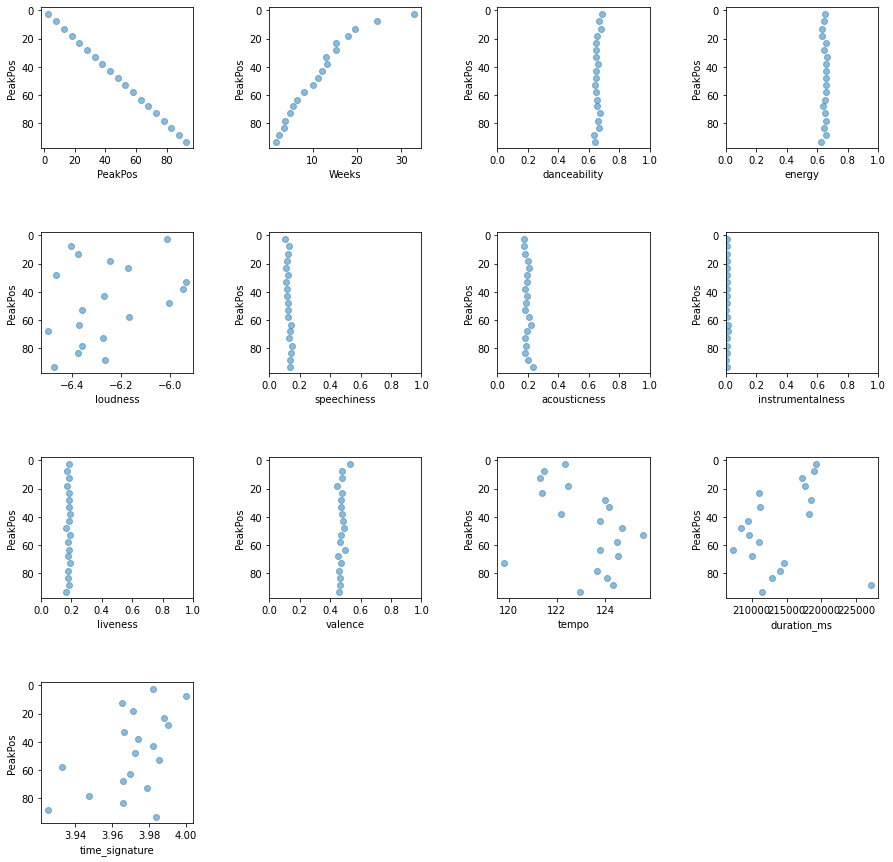

In [14]:
scatterplots(features, 'PeakPos', peak_pos, feature_key=zero_to_one_features, invert=True, ncol=4, figsize=(15, 15))

In [15]:
peak_pos_scale = peak_pos.drop(columns=['PeakPos','Weeks'])
peak_pos_scale_index = peak_pos_scale.index
peak_pos_scale_columns = peak_pos_scale.columns

In [16]:
peak_pos_scale = scale(peak_pos_scale)

peak_pos_scaled_df = pd.DataFrame(peak_pos_scale, columns=peak_pos_scale_columns)
peak_pos_scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2.353707,0.259130,1.425950,-1.841427,-1.503845,-0.674946,0.094530,3.116446,-0.605647,1.038950,0.618714
1,0.846012,-0.533191,-0.817982,0.088596,-1.100747,1.262183,-1.420956,0.231658,-1.196548,0.984543,1.592116
2,1.780351,-1.616947,-0.650938,-0.272127,-0.727087,-0.427619,0.545225,0.230050,-1.324637,0.647014,-0.301312
3,-0.118684,-1.850455,0.101083,-0.596323,0.287961,-0.559544,-1.420474,-1.647714,-0.529959,0.733566,0.022564
4,-0.528526,0.544447,0.521514,-1.259449,1.009154,-0.799540,0.576062,0.253248,-1.276997,-0.621615,0.945102


In [17]:
peak_pos_pca = PCA().fit(peak_pos_scale)

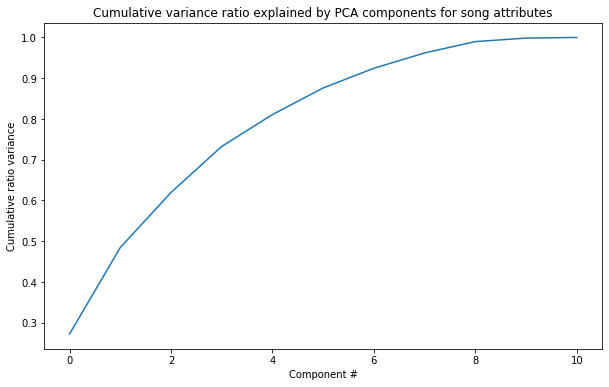

In [18]:
plt.subplots(figsize=(10, 6))
plt.plot(peak_pos_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [19]:
peak_pos_pca_x = peak_pos_pca.transform(peak_pos_scale)
peak_pos_pca_x.shape

(19, 11)

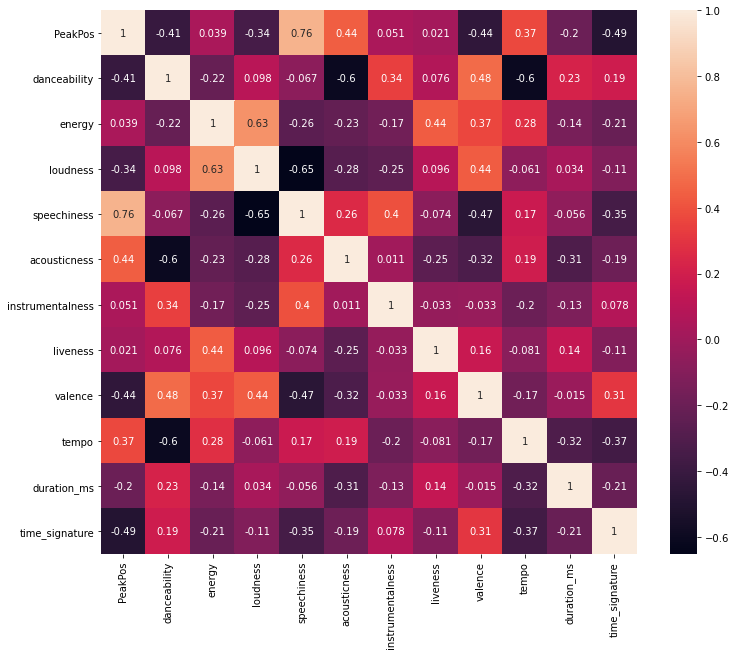

In [20]:
plt.subplots(figsize=(12,10))
corr_peak_pos = peak_pos.drop(columns='Weeks').corr()
sns.heatmap(corr_peak_pos,annot=True)
plt.show()

In [21]:
#Correlation with output variable
cor_target = abs(corr_peak_pos["PeakPos"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4].sort_values(ascending=False)
relevant_features

PeakPos           1.000000
speechiness       0.759698
time_signature    0.491688
valence           0.441049
acousticness      0.439004
danceability      0.409041
Name: PeakPos, dtype: float64

In [22]:
#remove valence, relatively high correlation to speechiness
print(peak_pos[["speechiness","valence"]].corr())

             speechiness   valence
speechiness     1.000000 -0.470981
valence        -0.470981  1.000000


### 3.2 Focus on Weeks on Billboard Chart

In [23]:
weeks = songs.drop(columns=['Rank','LastPos','Match_Ratio']).groupby(pd.cut(songs["Weeks"], np.arange(0, 100, 5))).mean()

#weeks

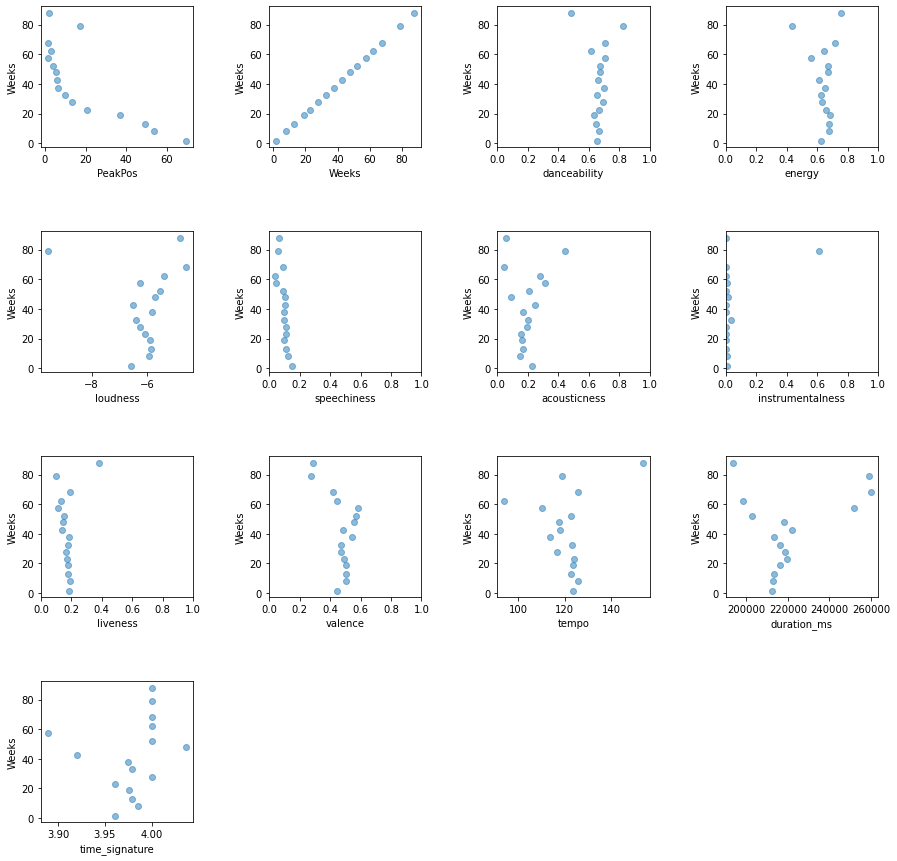

In [24]:
scatterplots(features, 'Weeks', weeks, feature_key=zero_to_one_features, ncol=4, figsize=(15, 15))

In [25]:
songs[songs.Weeks >= 55].sort_values(by='Weeks',ascending = False)

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks,SP_Title,SP_Artist,Match_Ratio,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
18,21,2021-08-28,Blinding Lights,The Weeknd,1,18,89,Blinding Lights,The Weeknd,100.0,...,-5.934,Major,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040.0,4.0
3681,49,2014-05-10,Radioactive,Imagine Dragons,3,48,87,Radioactive,Imagine Dragons,100.0,...,-3.686,Major,0.0627,0.10600,0.000108,0.6680,0.236,136.245,186813.0,4.0
3720,45,2014-03-22,Sail,AWOLNATION,17,41,79,Sail,AWOLNATION,100.0,...,-9.583,Major,0.0558,0.44100,0.615000,0.0964,0.272,119.051,259093.0,4.0
4328,49,2012-07-21,Party Rock Anthem,LMFAO Featuring Lauren Bennett & GoonRock,1,50,68,Party Rock Anthem,LMFAO,100.0,...,-4.210,Minor,0.1420,0.01890,0.000000,0.2660,0.359,129.993,262173.0,4.0
3524,50,2014-10-18,Counting Stars,OneRepublic,2,47,68,Counting Stars,OneRepublic,100.0,...,-4.972,Minor,0.0382,0.06540,0.000000,0.1150,0.477,122.017,257840.0,4.0
4415,49,2012-04-14,Rolling In The Deep,Adele,1,43,65,Rolling in the Deep,Adele,100.0,...,-5.114,Major,0.0298,0.13800,0.000000,0.0473,0.507,104.948,228093.0,4.0
367,24,2021-03-13,I Hope,Gabby Barrett Featuring Charlie Puth,3,18,62,I Hope,Gabby Barrett,100.0,...,-6.227,Major,0.0429,0.09510,0.000000,0.1140,0.377,75.998,210773.0,4.0
3956,50,2013-08-24,Ho Hey,The Lumineers,3,44,62,Ho Hey,The Lumineers,100.0,...,-9.074,Major,0.0304,0.79400,0.000002,0.0915,0.353,79.936,163133.0,4.0
3615,47,2014-07-05,Demons,Imagine Dragons,6,45,61,Demons,Imagine Dragons,100.0,...,-3.015,Major,0.0321,0.19000,0.000250,0.3290,0.428,89.938,175200.0,4.0
596,18,2020-11-07,Circles,Post Malone,1,19,61,Circles,Post Malone,100.0,...,-3.497,Major,0.0395,0.19200,0.002440,0.0863,0.553,120.042,215280.0,4.0


In [26]:
weeks = weeks.dropna()
weeks_scale = weeks.drop(columns=['PeakPos','Weeks'])
weeks_scale_index = weeks_scale.index
weeks_scale_columns = weeks_scale.columns

weeks_scale = scale(weeks_scale)

weeks_scaled_df = pd.DataFrame(weeks_scale, columns=weeks_scale_columns)
weeks_scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.164231,-0.255961,-0.489537,2.069933,0.324035,-0.231647,0.217937,-0.294395,0.219627,-0.429218,-0.544159
1,-0.019958,0.495345,0.123175,0.990674,-0.443714,-0.249989,0.303817,0.351688,0.422331,-0.389950,0.203535
2,-0.244195,0.501184,0.213674,0.541729,-0.253885,-0.274816,0.019012,0.357864,0.149233,-0.373529,0.013962
3,-0.459636,0.602691,0.158280,0.273209,-0.358219,-0.278068,0.098809,0.362805,0.241960,-0.226774,-0.096673
4,-0.037905,0.220810,-0.015032,0.610860,-0.380874,-0.296012,-0.021572,0.258468,0.269445,-0.055549,-0.519334


In [27]:
weeks_pca = PCA().fit(weeks_scale)

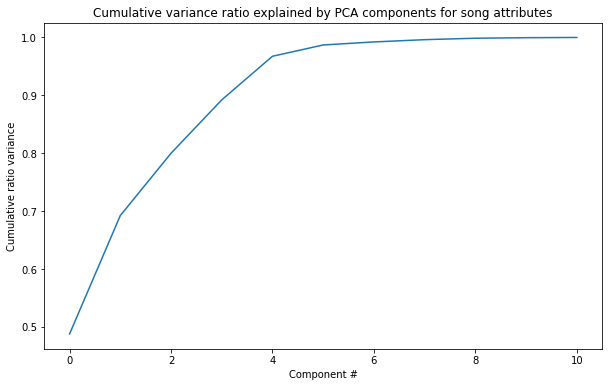

In [28]:
plt.subplots(figsize=(10, 6))
plt.plot(weeks_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [29]:
weeks_pca_x = weeks_pca.transform(weeks_scale)
weeks_pca_x.shape

(16, 11)

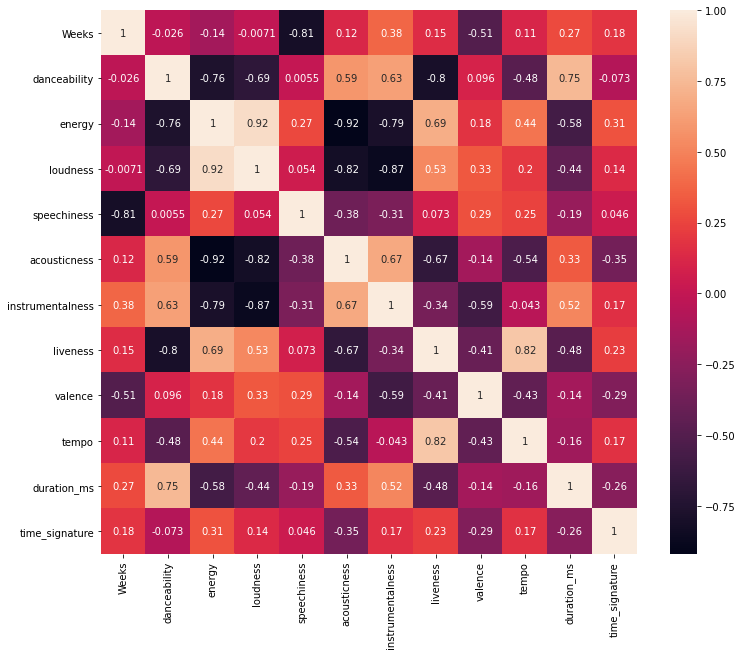

In [30]:
plt.subplots(figsize=(12,10))
corr_weeks = weeks.drop(columns='PeakPos').corr()
sns.heatmap(corr_weeks,annot=True)
plt.show()

In [31]:
#Correlation with output variable
cor_target = abs(corr_weeks["Weeks"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4].sort_values(ascending=False)
relevant_features

Weeks          1.000000
speechiness    0.814132
valence        0.506615
Name: Weeks, dtype: float64

### 3.3 Focus on "Most Successful" Songs

In [32]:
popular = songs[(songs.Weeks >= 4) & (songs.PeakPos <= 10)]

popular_by_year = popular.groupby(by=popular['Date'].dt.year).mean()

#popular_by_year[features]

In [33]:
popular_genres = [str(item) for item in popular['Genres'].to_list()]

popular_genre_list = []

for item in popular_genres:
    popular_genre_list.extend(item.split(','))

#Counter(popular_genre_list).most_common()

In [34]:
other = songs[~songs.SP_id.isin(popular.SP_id)]

other_by_year = other.groupby(by=other['Date'].dt.year).mean()

#other_by_year[features]

## 4.0 Summary

Left to do:
1) Summary
2) Better understand the scaled data etc.
3) Do something with Genre
4) EDA for classification problems

Questions
If I scaled the data - do I not have an issue that the lower populated sections get as much credit as the ones with a higher population because it isn't weighted?